# SalishSeaCast 2015-2019 summary

Figs. 4, 5 and S1 from Moore-Maley and Allen, 2021, Ocean Sci.:

***

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, dates, patches, gridspec
from datetime import datetime, timedelta
from scipy import signal
from tqdm.notebook import tqdm

%matplotlib inline

In [12]:
plt.rcParams['font.size'] = 12

***

### Load and process results

Load aggregated results file

In [3]:
# Load aggregated results file
ds = xr.open_dataset('/data/bmoorema/results/EOF_paper/EOF_paper_model_fields.nc').load()

Define MODIS dates and open water region and coastline points for calculating spatial medians

In [4]:
# Define MODIS dates
MODIS_dates = [
    datetime(2015, 9,  4, 21, 40,  0),
    datetime(2016, 7, 30, 20, 35, 10),
    datetime(2018, 9, 12, 21, 40,  1),
    datetime(2019, 6, 20, 21, 30,  0),
]

# Define open water mask
openwatermask = np.copy(ds.landmask)
openwatermask[:120, :] = 0     # Southern end
openwatermask[410:, :] = 0     # Northern end
openwatermask[:170, :130] = 0  # Gulf Islands
openwatermask[:, 190:] = 0     # Fraser River/Howe Sound
openwatermask[280:, 130:] = 0  # Jervis Inlet
waterpoints = openwatermask.ravel().astype('bool')

# Define section points
# [(xmin, xmax, xstep), (yint, yslope)]
sectionargs = [
    [( 20,  45, 13), (490, -4)], # VI north
    [( 30, 130, 17), (315, -1)], # VI south
    [( 70,  88, 10), (620, -3)], # SC north
    [( 60,  85, 10), (460, -2)], # SC Texada
    [(130, 175, 10), (375, -1)], # SC south
]
sections = {'Vancouver Island': [], 'Sunshine Coast': []}
for section in sections:
    slc = (None, 2) if section == 'Vancouver Island' else (2, None)
    for args in sectionargs[slice(*slc)]:
        i = np.linspace(*args[0]).astype(int)
        j = (args[1][0] + args[1][1] * i).astype(int)
        sections[section].append([j, i])
    sections[section] = np.hstack(sections[section])

Process data

In [5]:
# Process data
data = {
    'time': ds.time.values.astype('datetime64[s]').astype(datetime),
    'v_along': ds.v_along.values, 'temperature': {}, 'nitrate': {},
}
for var in tqdm(['temperature', 'nitrate']):
    raw = ds[var].values.reshape(-1, len(waterpoints))[:, waterpoints]
    data[var]['openwater'] = {p: np.percentile(raw, p, axis=1) for p in (25, 50, 75)}
    for section in sections:
        raw = ds[var].values[(slice(None),) + tuple(sections[section])]
        data[var][section] = {p: np.percentile(raw, p, axis=1) for p in (25, 50, 75)}

  0%|          | 0/2 [00:00<?, ?it/s]

Calculate spring and fall cutoffs to define "productive season"

In [6]:
# Calculate seasonal indices
threshold, lag = 2, 5
isegments, iseason = [], []
for year in range(2015, 2020):
    index = np.array([datetime(year, 1, 1) <= t < datetime(year+1, 1, 1) for t in data['time']])
    bounds = np.ma.where(np.ma.masked_where(index==0, data['nitrate']['openwater'][50]) < threshold)[0][[0, -1]]
    bounds = [bound + lag * hour for bound, hour in zip(bounds, [24, -24])]
    isegments.append(bounds)
    iseason.append(np.arange(*bounds))
iseason = np.hstack(iseason)

***

### Plot 2015-2019 hindcast summary

Define plotting functions

In [ ]:
def make_panel(fig, gs, variables, regions, colors, xlim, ylim, cutoff=48, IQR=False):
    """Create a double y-axis panel, plot wind and surface tracers
    and apply standard formatting
    """
    
    # Time index and smoothing window
    index = np.array([xlim[0] <= t <= xlim[1] for t in data['time']])
    window = signal.get_window('blackman', cutoff)
    
    # Formatting
    ax_left = fig.add_subplot(gs)
    ax_left.patch.set_visible(False)
    ax_left.set_zorder(1)
    ax_left.set_xlim(xlim)
    ax_left.set_ylim(ylim)
    ax_right = ax_left.twinx()
    ax_right.patch.set_visible(True)
    ax_right.set_ylim([-11, 11])
    ax_right.tick_params(axis='y', colors='gray')
    
    # Plot tracers
    for var, color1 in zip(variables, colors):
        for region, color2 in zip(regions, colors):
            if len(variables) > 1: color, label = color1, var.capitalize()
            elif len(regions) > 1: color, label = color2, region
            else: color, label = 'k', None
            p25, p50, p75 = [signal.convolve(data[var][region][p], window / sum(window), mode='same') for p in (25, 50, 75)]
            ax_left.plot(data['time'][index], p50[index], '-', color=color, label=label)
            if IQR:
                ax_left.fill_between(data['time'][index], p25[index], p75[index], fc=color, ec=color, alpha=0.2)
    
    # Only plot wind and MODIS dates if IQR is off
    if not IQR:
    
        # Plot wind
        v_along = signal.convolve(data['v_along'], window / sum(window), mode='same')
        ax_right.fill_between(data['time'][index], v_along[index], ec='gray', fc='lightgray', label='HRDPS')

        # Plot MODIS dates
        for date in MODIS_dates:
            if date.year == xlim[0].year:
                ax_right.plot([date, date], [-11, 11], '-', color='lime')
    
    return (ax_left, ax_right)


def plot_hindcast(IQR=False):
    """Plot the 2015-2019 hindcast summary
    """

    fig = plt.figure(figsize=(14, 10))
    gs = plt.GridSpec(6, 2, wspace=0.2)

    # Plot data and standard formatting
    variables, colors = ['nitrate', 'temperature'], ['r', 'k']
    xlim, ylim = [datetime(2015, 1, 1), datetime(2020, 1, 1)], [0, 25]
    axs = make_panel(fig, gs[0, :], variables, ['openwater'], colors, xlim, ylim, cutoff=120, IQR=IQR)

    # Plot seasonal cutoffs as white patches (if IQR is off)
    if not IQR:
        for segment in isegments:
            timerange = [data['time'][i] for i in segment]
            axs[1].add_patch(patches.Rectangle([timerange[0], -11], np.diff(timerange)[0], 22, fc='w', zorder=0))

    # Extra formatting
    pos = axs[0].get_position()
    axs[0].set_position([pos.x0, pos.y0+0.05, pos.width, pos.height])
    axs[0].set_title('Median open water surface tracers', fontsize=12)
    axs[0].set_ylabel('[$\mu$M] or [$^{\circ}$C]')
    axs[0].legend(loc=(0.35, -0.5), ncol=2, frameon=False)
    axs[0].text(0.004, 0.05, '(a)', transform=axs[0].transAxes)
    axs[1].set_ylabel('[m s$^{-1}$]', color='gray')
    if not IQR: axs[1].set_facecolor((0.92, 0.96, 1))

    # Bottom panels
    k = 1
    for row, year, segment in zip(range(1, 6), range(2015, 2020), isegments):
        for col, var, units in zip(range(2), ['nitrate', 'temperature'], ['[$\mu$M]', '[$^{\circ}$C]']):

            # Plot data and standard formatting
            regions, colors = ['Vancouver Island', 'Sunshine Coast'], ['steelblue', 'orange']
            xlim = [datetime(year, 3, 28), datetime(year, 9, 15)]
            ylim = (5, 25) if var == 'temperature' else (0, 25)
            axs = make_panel(fig, gs[row, col], [var], regions, colors, xlim, ylim, IQR=IQR)

            # Plot seasonal cutoffs (if IQR is off)
            if not IQR:
                for i in segment:
                    axs[1].plot([data['time'][i], data['time'][i]], [-11, 11], 'm--')

            # Extra formatting
            axs[0].xaxis.set_major_locator(dates.MonthLocator(interval=1))
            axs[0].xaxis.set_major_formatter(dates.DateFormatter('%b'))
            if year < 2019: axs[0].xaxis.set_ticklabels('')
            if year == 2015: axs[0].set_title(f'Surface {var}', fontsize=12)
            if year == 2017:
                axs[0].set_ylabel(units, labelpad=-1)
                if var == 'temperature':
                    axs[1].set_ylabel('Along-axis wind speed [m s$^{-1}$]', color='gray')
            axs[0].text(0.95, 0.85, f'({chr(97+k)})', transform=axs[0].transAxes)
            k += 1

    axs[0].legend(loc=(-0.45, -0.6), ncol=2, frameon=False)
    if not IQR:
        axs[1].legend(loc=(-0.7, -0.6), frameon=False)

Plot the standary hindcast summary figure (Fig. 5)

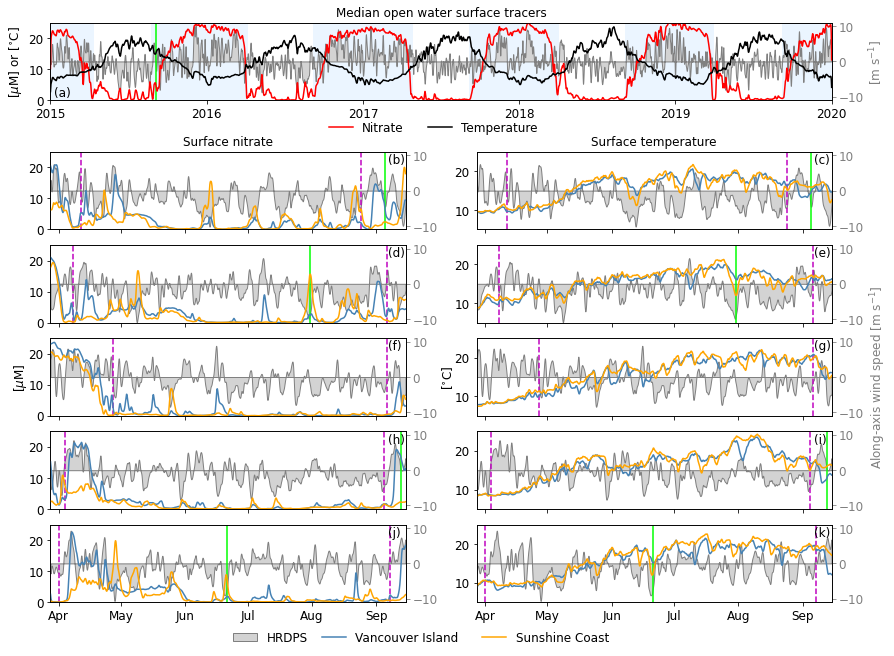

In [36]:
# Plot the standary hindcast summary figure (Fig. 5)
plot_hindcast(IQR=False)

Plot the supplement hindcast summary figure with IQR (Fig. S1)

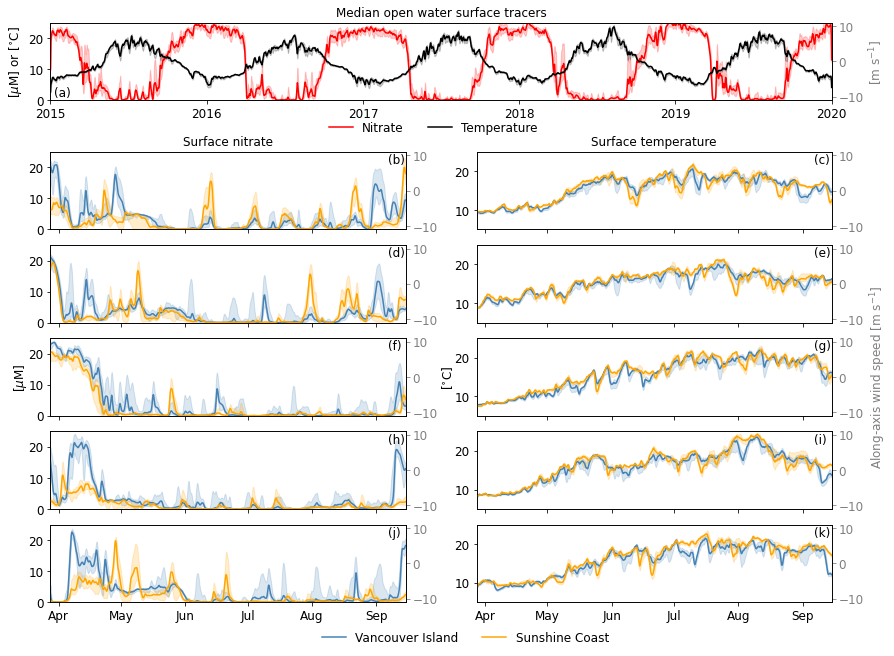

In [37]:
# Plot the supplement hindcast summary figure with IQR (Fig. S1)
plot_hindcast(IQR=True)

***

### Extra code

In [20]:
# Loop through year, variables and stations
landmask = np.copy(tmask.values[slice(*subdomain[2:]), slice(*subdomain[:2])])
landmask[:120, :] = 0
landmask[410:, :] = 0
landmask[:170, :130] = 0
landmask[:, 190:] = 0
landmask[280:, 130:] = 0
landmask = landmask[::10, ::10].reshape(-1).astype('bool')

profiles = {'votemper': [], 'nitrate': []}
slc = {'x': slice(*subdomain[:2], 10), 'y': slice(*subdomain[2:], 10)}
for year in range(2015, 2020):
    start, end = [datetime(year, *md) for md in cutoffs[year]]
    for day in tqdm(range((end - start).days), f'Loading {year}'):
        for var in ['votemper', 'nitrate']:
            filestr = 'ptrc_T' if var == 'nitrate' else 'grid_T'
            with xr.open_dataset(f'{nc_tools.get_hindcast_prefix(start + timedelta(day))}_{filestr}.nc') as ds:
                profiles[var].append(ds[var].isel(slc).values.reshape(24, 40, len(landmask))[..., landmask])

Loading 2015:   0%|          | 0/134 [00:00<?, ?it/s]

Loading 2016:   0%|          | 0/137 [00:00<?, ?it/s]

Loading 2017:   0%|          | 0/130 [00:00<?, ?it/s]

Loading 2018:   0%|          | 0/150 [00:00<?, ?it/s]

Loading 2019:   0%|          | 0/157 [00:00<?, ?it/s]

In [22]:
profiles2 = {}
for var in ['votemper', 'nitrate']:
    profiles2[var] = np.concatenate(profiles[var])

In [26]:
deptht = ds.deptht.values

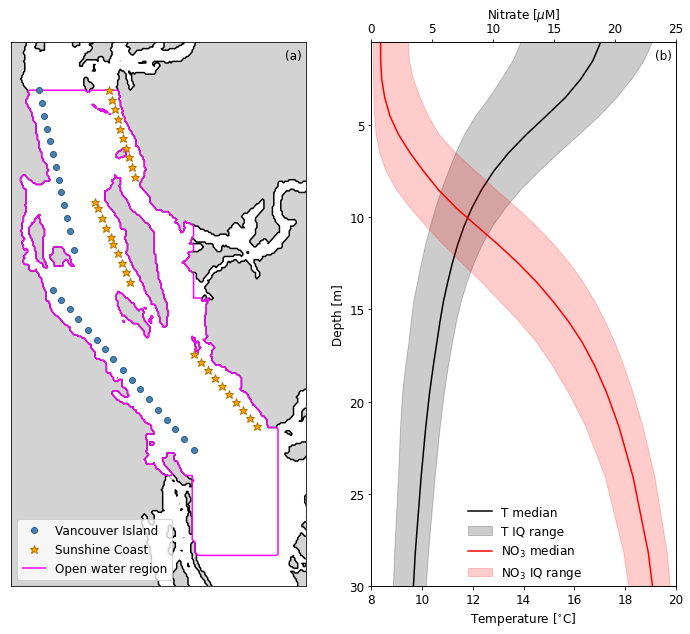

In [45]:
# Plot regions
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
ax = axs[0]
x, y = tmask.x[slice(*subdomain[:2])].values, tmask.y[slice(*subdomain[2:])].values
ax.set_xlim([110, 320])
ax.set_ylim([400, 740])
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_aspect(5/4.4)
landmask = np.copy(tmask.values[slice(*subdomain[2:]), slice(*subdomain[:2])])
ax.contourf(x, y, landmask, levels=[-0.01, 0.01], colors='lightgray')
ax.contour(x, y, landmask, levels=[-0.01, 0.01], colors='k')
landmask[:120, :] = 0
landmask[410:, :] = 0
landmask[:170, :130] = 0
landmask[:, 190:] = 0
landmask[280:, 130:] = 0
c = ax.contour(x, y, landmask, levels=[-0.01, 0.01], colors='magenta')
c.collections[1].set_label('Open water region')
for section, label, color, marker, ms in zip(sections, ['Vancouver Island', 'Sunshine Coast'], ['steelblue', 'orange'], ['o', '*'], [6, 9]):
    ax.plot(section['x'], section['y'], marker, ms=ms, mec=np.array(colors.to_rgb(color))*0.7, mfc=color, label=label)
ax.legend(loc=3)
ax.text(0.93, 0.97, '(a)', transform=ax.transAxes)

ax2 = axs[1].twiny()
axs[1].set_ylim([30, 0.5])
axs[1].set_ylabel('Depth [m]')
for ax, var, xlim, label, xlabel, color, ypos in zip(
    [axs[1], ax2], ['votemper', 'nitrate'], [(8, 20), (0, 25)], ['T', 'NO$_3$'], ['Temperature [$^{\circ}$C]', 'Nitrate [$\mu$M]'], ['k', 'r'], [0.08, 0],
):
    percentiles = np.percentile(profiles2[var], [25, 50, 75], axis=(0, 2))
    ax.fill_betweenx(deptht, *percentiles[(0, 2), :], ec=color, fc=color, alpha=0.2, label=f'{label} IQ range')
    ax.plot(percentiles[1, :], deptht, '-', color=color, label=f'{label} median')
    ax.set_xlim(xlim)
    ax.set_xlabel(xlabel)
    ax.legend(loc=(0.3, ypos), frameon=False)
ax.text(0.93, 0.97, '(b)', transform=ax.transAxes)
#fig.savefig('/home/bmoorema/Desktop/revision_figs/spatialavgs_profiles.pdf', bbox_inches='tight')